# Assignment 6 - Smridhi Patwari smridhip
# Hands-on exercise with the BETH cyber dataset

## *Background*

BETH is real cybersecurity dataset published in 2021 as a benchmark for anomaly detection researchers. The data contain about 8 million records generated by 23 hosts over five (discontiguous) hours. Data for each host includes benign traffic as well as at most one single attack. Crucially, each record is labeled as to whether it is "benign" or "evil."

In this exercise, we'll use the BETH dataset to demonstrate:

1.   Cyber data visualization
2.   Attack identification by ML-based anomaly detection

For additional information on BETH, refer to:

*   Highnam, K., Arulkumaran, K., Hanif, Z., & Jennings, N. R. (2021). BETH dataset: Real cybersecurity data for anomaly detection research. In *ICML 2021 Workshop on Uncertainty and Robustness in Deep Learning*. http://www.gatsby.ucl.ac.uk/~balaji/udl2021/accepted-papers/UDL2021-paper-033.pdf

First, import the data into the environment. 

Note that the full BETH dataset contains 8 million records, and we work with a small sample for this exercise.

# Import libraries
Now import all libraries required for the notebook:

*   'matplotlib' is for plotting.
*   'numpy' is a low-overhead data management library using arrays.
*   'pandas' is a high-overhead data management library that uses dataframes, which include many convenient methods for exploring and processing the data.
*   'sklearn' is a data science library that contains many convenient methods for predictive modeling.
*   'umap' implements a dimensionality reduction technique, which we'll use to visualize and try to identify clusters in our data. Note that the 'umap' library does not come with CoLab, and it needs to be installed into the environment by the '!pip install umap-learn' command (see code window below).

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import sklearn.ensemble
import sklearn.metrics
import sklearn.preprocessing

###########################
###########################
# STUDENTS ADD CODE HERE TO:
# Install and import umap-learn into the environement
import umap

###########################
###########################

/opt/anaconda3/envs/general/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import data and view fields

We'll import 'data.csv' into a pandas dataframe. The following field descriptions are provided by Highnam (2021):

*   *timestamp*: seconds since system boot
*   *processId*: integer label for the process spawning this log
*   *threadId*: integer label for the thread spawning this log
*   *parentProcessId*: parent's integer label for the process spawning this log
*   *userId*: login integer ID of user spawning this log
*   *mountNamespace*: set mounting restrictions this process log works within
*   *processName*: string command executed
*   *hostName*: name of host server
*   *eventId*: ID for the event generating this log
*   *eventName*: name of the event generating this log
*   *stackAddresses*: memory values relevant to the process
*   *args*: list of arguments passed to this process
*   *argsNum*: length of 'args'
*   *returnValue*: value returned from this event log (usually 0)
*   *sus*: binary label as a suspicious event (1 is suspicious, 0 is not)
*   *evil*: binary label as a known malicious event (1 is malicious, 0 is not)

In [2]:
###########################
###########################
# STUDENTS ADD CODE HERE TO:
# Read 'data.csv' into a pandas dataframe called 'df', and then
# Inspect the data type of each column in 'df'.
df = pandas.read_csv('data_Assignment_1.csv')
print(df.dtypes)

###########################
###########################

timestamp          float64
processId            int64
threadId             int64
parentProcessId      int64
userId               int64
mountNamespace       int64
processName         object
hostName            object
eventId              int64
eventName           object
stackAddresses      object
argsNum              int64
returnValue          int64
args                object
sus                  int64
evil                 int64
dtype: object


# View first 5 records

'df.head()' prints the first 5 records, which provides an initial understanding of the fields, data types, and data scales. Observe that:

*   some fields are *strings*
*   one field is a dictionary

In [3]:
###########################
###########################
# STUDENTS ADD CODE HERE TO:
# Print and inspect the first 5 records
df.head(5)

###########################
###########################

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,124.439221,381,381,1,101,4026532232,systemd-resolve,ip-10-100-1-129,41,socket,"[139913106282763, 139913103116537, 94901962555...",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
1,124.439751,378,378,1,100,4026532231,systemd-network,ip-10-100-1-129,41,socket,"[140343254628619, 93967981149065, 93967990898192]",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
2,124.439958,1,1,0,0,4026531840,systemd,ip-10-100-1-129,1005,security_file_open,"[140074839310116, 8103505641674583864]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
3,124.440007,1,1,0,0,4026531840,systemd,ip-10-100-1-129,257,openat,[],4,12,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
4,124.440037,1,1,0,0,4026531840,systemd,ip-10-100-1-129,5,fstat,[140074839307913],2,0,"[{'name': 'fd', 'type': 'int', 'value': 12}, {...",0,0


# Histograms of the raw data (numeric fields only)

Observe that:

*   there are many different scales, and the data are not Gaussian (i.e., not normal)
*   many fields are *categorical* and not numeric (despite their dtypes being int64)
*   some fields are *binary* (despite their dtypes being int64)
*   some fields contain *imbalanced* data

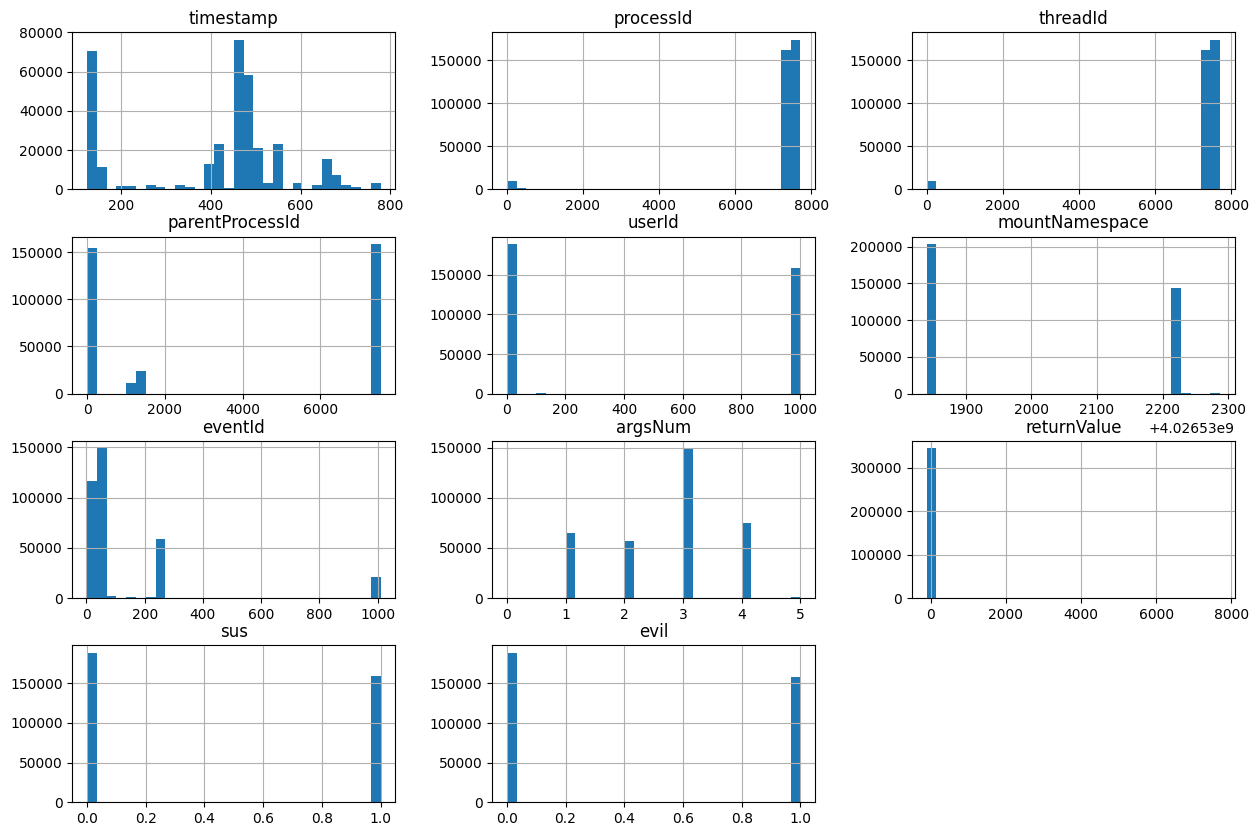

In [4]:
###########################
###########################
# STUDENTS ADD CODE HERE TO:
# Generate histograms of the raw data.
df.hist(bins=30, figsize=(15, 10))
plt.show()

###########################
###########################

# Feature engineering (pre-processing)
Here we use our knowledge of the system being monitored, including what each field actually represents. to transform each feature (field) into a form that is most meaningful for our ultimate goal of detecting malicious activity. Highnam et al. (2021) provides the following preprocessing suggestions (quoted from http://www.gatsby.ucl.ac.uk/~balaji/udl2021/accepted-papers/UDL2021-paper-033.pdf):

*   *timestamp*: "We left this field out to consider the dataset as a sample from a distribution rather than time series. We recommend using the values as they are or also leave them out, depending on the method chosen."
*   *processId*: "Process IDs 0, 1, and 2 are meaningful since these are always values used by the OS, but otherwise a random number is assigned to the process upon creation. We recommend replacing processId with a binary variable indicating whether or not processID is 0, 1, or 2."
*   *threadId*: "While this value did not appear useful in our analysis, it might suggest how to link process calls if obfuscated in the system. No conversion is recommended at this time." We retain *threadId* without modification for this excercise.
*   *parentProcessId*: "Same as processId, the same mapping to a binary variable should suffice."
*   *userId*: "The default in Linux systems is to assign OS activity to some number below 1000 (typically 0). As users login, they are assigned IDs starting at 1000, incrementally. This can be altered by a user, but none of the current logs gave evidence an attacker did this. We used a binary variable to indicate userId < 1000 or userId   1000. Alternatively, one could use an ordinal mapping that buckets all userId < 1000 at zero and then increment upwards for each new user. Also, no more than four logins were viewed per host in our current datasets."
*   *mountNamespace*: "This field is somewhat consistent across our hosts and determines the access a certain process has to various mount points. The most common value for this feature is 4026531840 or 0xF0000000, which is for the mnt/ directory where all manually mounted points are linked. It is noted that all logs with userId   1000 had a mountNamespace of 4026531840, while some OS
userId traffic used different mountNamespace values. We converted this feature into a binary mapping for whether or not mountNamespace = 4026531840."
*   *processName*: "This is a string field of variable length (ranging from one to fifteen characters). When manually analying the data, this was a critical field in conjunction with the eventName. For our baselines, we refrained from utilising this, although the model should be given an encoding of this using a hash or ability to learn a useful encoding on its own. It is noted that attackers can easily change the processName to override a benign one so their traffic looks regular. This was not observed within the current dataset."
*   *hostName*: "This field is useful for grouping the dataset into related subsets of data generated from the same honeypot. The name of the host name does not transfer between the model development subsets described in this paper."
*   *eventId*: "Linux systems assign an integer corresponding to the eventName. We include this field as is for our benchmarks."
*   *eventName*: "Event names uniquely map to eventId, so we drop it from training."
*   *stackAddresses*: "It is difficult to clearly relate this feature during manual analysis and the large values within a variable size list make processing automatically difficult without encoding or learning an extra embedding. Thus this field was dropped from training our baselines."
*   *args*: "There are many options in this variable list of dictionaries. For simplicity, we refrain from utilising any of these values. However, more features can and should be created for future work."
*   *argsNum*: "This raw feature is included as-is, since, at this time, adequately parsing args requires either more sophisticated pre-processing or a more complex ML model."
*   *returnValue*: "This is also called the exit status and can be used to determine whether a call completed successfully or not. Mappings for this can vary, as this value is decided between the parent and child process. We mapped
returnValue into three values based on the common usage of the field: -1 when negative (bad errors), 0 when zero (success), and 1 when positive (success and signaling something to the parent process)."
*   *sus*: Flag indicating whether record was suspicious (1) or not (0)
*   *evil*: Flag indicating whether record was malicious (1) or not (0)

The following function, which we'll call during our analysis, implements the above preprocessing recommended by Highnam et al. (2021)


In [5]:
# Function to pre-process the data according to recommendations by
# the dataset creators (Highnam et al. 2021)

# argument: dataframe to pre-process
# return: pre-processed dataframe, feature set, and target set

def preprocess(df):

  df_eng = df.copy(deep=True)
  df_eng = df_eng.drop(['timestamp'], axis=1)
  df_eng.loc[df_eng['processId'] <= 2, 'processId'] = 0
  df_eng.loc[df_eng['processId'] > 2, 'processId'] = 1
  df_eng = df_eng.drop(['threadId'], axis=1)
  df_eng.loc[df_eng['parentProcessId'] <= 2, 'parentProcessId'] = 0
  df_eng.loc[df_eng['parentProcessId'] > 2, 'parentProcessId'] = 1
  df_eng.loc[df_eng['userId'] < 1000, 'userId'] = 0
  df_eng.loc[df_eng['userId'] >= 1000, 'userId'] = 1
  df_eng.loc[df_eng['mountNamespace'] != 4026531840, 'mountNamespace'] = 0
  df_eng.loc[df_eng['mountNamespace'] == 4026531840, 'mountNamespace'] = 1
  df_eng = df_eng.drop(['processName'], axis=1)
  df_eng = df_eng.drop(['hostName'], axis=1)
  df_eng = df_eng.drop(['eventName'], axis=1)
  df_eng = df_eng.drop(['stackAddresses'], axis=1)
  df_eng.loc[df_eng['returnValue'] < 0, 'returnValue'] = -1
  df_eng.loc[df_eng['returnValue'] == 0, 'returnValue'] = 0
  df_eng.loc[df_eng['returnValue'] > 0, 'returnValue'] = 1
  df_eng = df_eng.drop(['args'], axis=1)
  df_eng = df_eng.drop(['sus'], axis=1) # drop 'sus' to challenge our preictive models

  X = df_eng.drop('evil', axis=1)
  y = df_eng['evil'].values.flatten()

  return df_eng, X, y

# Histograms of the engineered features

Note that the 'preprocess()' function returns a features dataframe (X) and a response dataframe (y). Here we only plot the features.

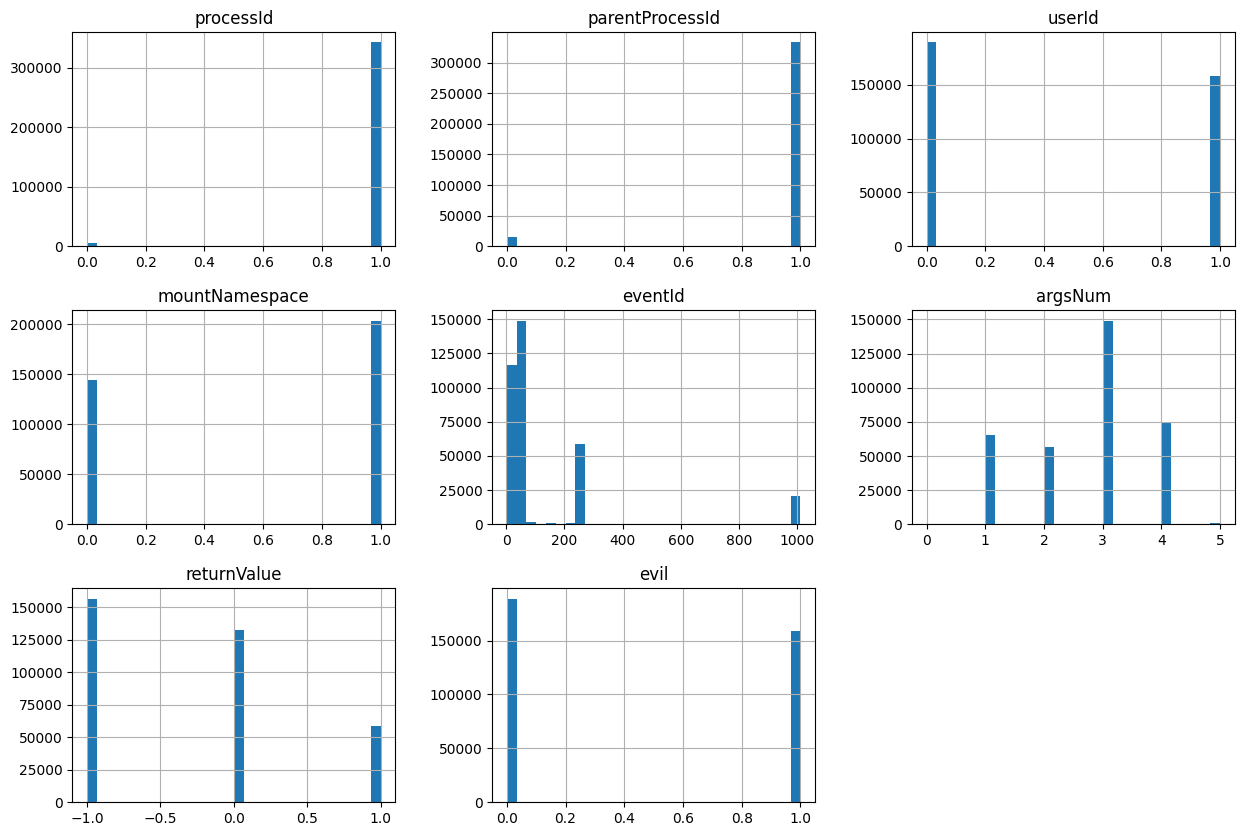

In [6]:
###########################
###########################
# STUDENTS ADD CODE HERE TO:
# Call preprocess(df) to perform feature engineering, and then
# Generate histograms of the engineered features.
df_eng, X, y = preprocess(df)
df_eng.hist(bins=30, figsize=(15, 10))
plt.show()


###########################
###########################

# Correlation Plot
We'll compute the correlation between each pair of variables in the pre-processed data. Correlation is a measure of how linearly related two variables are to each other. We'll then visualize the correlations in a heatmap.


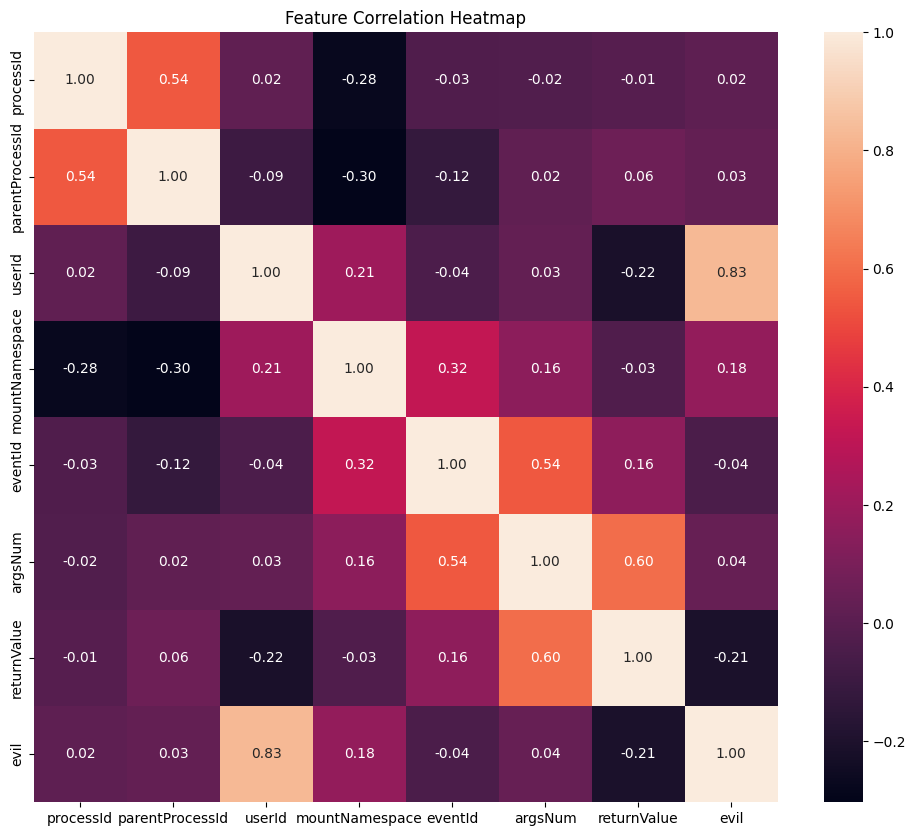

In [11]:
###########################
###########################
# STUDENTS ADD CODE HERE TO:
# Use the pandas method corr() to compute pairwise correlations
# between all engineered features, and then
# plot the correlations with the seaborn heatmap() method.
corr_matrix = df_eng.corr()
plt.figure(figsize=(12, 10))
seaborn.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


###########################
###########################

# Generate random sample for modeling

The following function generates a sample of the data for modeling. Note that the full BETH dataset contains over 8 million records, and we downsample in this excercise for tractability.

In [12]:
# Function to generate a sample of data for modeling, containing the desired
# proportions of benign and evil records.

# arguments: sample size (n) and desired percent of evil records (pct_evil)
# return: dataframe with (n) records, of which (pct_evil) percent are evil and (1-pct_evil) are benign.

def get_sample(n, pct_evil):

  df = pandas.read_csv('data_Assignment_1.csv')
  df1 = df[df['evil'] == 0].sample(int(n * (1-pct_evil)))
  df2 = df[df['evil'] == 1].sample(int(n * pct_evil))
  df = pandas.concat([df1, df2])

  return df

# Dimensionality reduction and visualization

Here we apply a dimensionality reduction technique called UMAP. It  projects high-dimensional data onto a lower-dimensional (e.g., 2D) space, while preserving as much structure of the original data as possible.

The resulting plot shows that both benign (purpol) and malicious records (yellow) form tight clusters, and there does not appear to be significant overlap between the clusters. This suggests that there might be structural properties of the data that can be exploited to distinguish between benign and malicious traffic.

/opt/anaconda3/envs/general/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'Clustering of Benign (Purple) and Malicious (Yellow) Log Events')

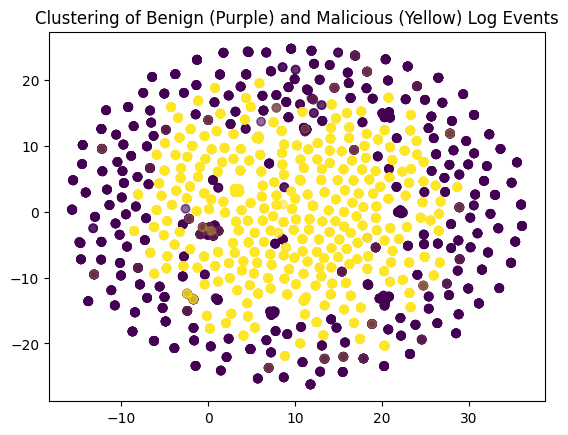

In [13]:
# Get balanced data sample containing 25,000 records,
# in which 50% are evil and 50% are benign
df = get_sample(25000, 0.50)

# Preprocess, center, and scale the features.
df_eng, X, y = preprocess(df)
scaler = sklearn.preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)


###########################
###########################
# STUDENTS ADD CODE HERE TO:
# Train a UMAP dimensionality reducing model using the umap.UMAP() method, then
# Transform the engineered features using the trained UMAP model.
reducer = umap.UMAP(n_components=2, random_state=42)
X_reduced = reducer.fit_transform(X)


###########################
###########################


# Plot the UMAP-transformed data. The distinct clustering of the
# evil traffic suggests that it should be detectable by
# anomaly detection methods.
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, alpha=0.1)
plt.title('Clustering of Benign (Purple) and Malicious (Yellow) Log Events')

# Anomaly detection

We now train an anomaly detection model called "isolation forest." The goal of this model is to be able to accurately classify each cyber record as benign or malicious. We present the model performance as a confusion matrix, which indicates the true positive, true negative, false positive, and false negative classification rates.

The confusion matrix identifies that the model is very good at identifying malicious records; however, it has a high rate of misclassifying benign records as malicious (i.e., false positives). High false positive rates prevent deployment of anomaly detection models because they significantly distract analysts. Many anomaly detection models suffer from high false positive rates, and improving this picture is an active area of research.

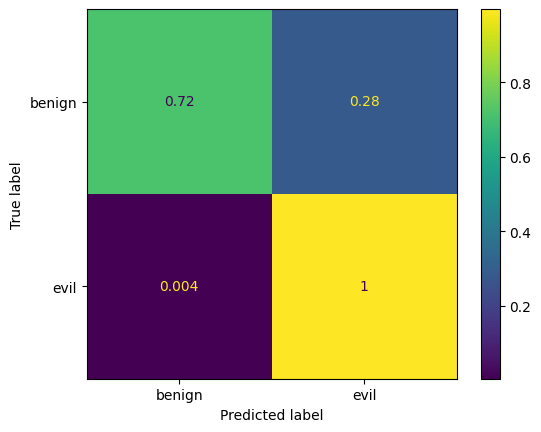

In [ ]:
# Get data sample containing 25,000 records, 1% of which are evil
df = get_sample(25000, 0.01)

# Preprocess the features. Note that we don't need to center and scale
# the features because the model form (isolation forest)
# is insensitive to features having different scales.
df_eng, X, y = preprocess(df)


###########################
###########################
# STUDENTS ADD CODE HERE TO:
# Fit an anomaly detecting isolation forest model to the engineered features
model = sklearn.ensemble.IsolationForest(contamination="auto", random_state=42)
model.fit(X)

###########################
###########################


# Use the trained model to classify each record as benign or evil
score = model.decision_function(X)
anomaly = model.predict(X)
evil = y
df3 = pandas.DataFrame ({'score':score, 'anomaly':anomaly, 'evil':evil})
df3.loc[df3['anomaly'] == 1, 'anomaly'] = 0
df3.loc[df3['anomaly'] == -1, 'anomaly'] = 1

# Compute and plot performance metrics as a "confusion matrix"
cm = sklearn.metrics.confusion_matrix(df3['evil'], df3['anomaly'])
num_ben = df[df['evil'] == 0].shape[0]
num_evil = df[df['evil'] == 1].shape[0]
cm_rate = numpy.divide(cm, numpy.array([[num_ben, num_ben], [num_evil, num_evil]]))
cm_rate = numpy.around(cm_rate, 5)
sklearn.metrics.ConfusionMatrixDisplay(cm_rate, display_labels=['benign','evil']).plot()